# Autoencoders

Here we'll apply an autoencoder to the MNIST dataset to see how much we can compress it.

In [32]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [33]:
#same as we did for CNNs
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5),(0.5))]) #convert from images to tensors

mnist_train = torchvision.datasets.MNIST("./mnist", train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST("./mnist", train=False, download=True, transform=transform)

We'll start with "dumb" networks that don't use convolution layers, and treat the image as a 1D vector with 28*28 entries.  Our first network will have 2 dense layers for the encoder, and 2 symmteric layers for the decoder, with a compressed representation of size 64 (over 10x reduction from the original size)

In [34]:
# Based on https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1

class Net( nn.Module ):

    def __init__( self, inputLen ):
        super(Net, self).__init__()
        self.inputLen = inputLen
        self.encodedSize = 64
        
        self.fc1 = nn.Linear(self.inputLen, 128)
        self.fc2 = nn.Linear(128, self.encodedSize) #scale down to 64 features
        
        self.fc3 = nn.Linear(self.encodedSize, 128)
        self.fc4 = nn.Linear(128, self.inputLen)
        
    def compress( self, x ):
        x = F.relu( self.fc1(x) )
        x = F.relu( self.fc2(x) )
        # Now we have a 64-d representation of our data.  If we were doing compression, we'd store this.
        return x
    
    def decompress( self, x ):
        x = F.relu( self.fc3(x) )
        x = self.fc4( x )
        return x
    
    def forward( self, x ):
        x = self.compress( x )
        x = self.decompress( x )
        return x

net = Net( 28*28 ) # treat these as just 28 D vectors

In [35]:
# mean-squared error loss
# this is the normal "least squares" error function, divided by the number of data points
criterion = nn.MSELoss()

def train( model, epochs ):
    # create an optimizer object
    # Adam optimizer with learning rate 1e-3
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=8, shuffle=True, num_workers=0)
    
    for epoch in range(epochs):
        loss = 0
        
        running_loss = 0
        
        for i, data in enumerate(train_loader, 0):

            #same as yesterday, except we're not even looking at the labels!
            # since we're not using a CNN, we need to "flatten" the input images
            batch_features = data[0].view(-1, 784)
        
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()
        
            # compute reconstructions
            outputs = model(batch_features)
        
            # compute training reconstruction loss
            # again, same idea as yesterday, but we're measuring the error slightly differently
            # how well does the reconstructed image match the input image?
            train_loss = criterion( outputs, batch_features )
        
            # compute accumulated gradients
            train_loss.backward()
        
            # perform parameter update based on current gradients
            optimizer.step()
        
            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()
    
            # print statistics
            running_loss += train_loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.8f' % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    
        # compute the epoch training loss
        loss = loss / len(train_loader)
    
        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.8f}".format(epoch + 1, epochs, loss))

def evaluate(model):
    test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=8, shuffle=True, num_workers=0)
    total_loss = 0
    with torch.no_grad():
        for data in test_loader:
            images = data[0].view(-1, 784)
            outputs = model(images)
            test_loss = criterion(outputs, images)
            total_loss += test_loss.item()

    print("overall loss: ", total_loss)

In [59]:
epochs = 4

print( "Train: (%d epochs)" % epochs ) 
train( net, epochs )

print( "Evaluate:" )
evaluate( net )

Train: (4 epochs)
[1,  2000] loss: 0.05498298
[1,  4000] loss: 0.05439688
[1,  6000] loss: 0.05400309
epoch : 1/4, loss = 0.05422458
[2,  2000] loss: 0.05298530
[2,  4000] loss: 0.05257207
[2,  6000] loss: 0.05247212
epoch : 2/4, loss = 0.05263595
[3,  2000] loss: 0.05194765
[3,  4000] loss: 0.05156255
[3,  6000] loss: 0.05140461
epoch : 3/4, loss = 0.05163269
[4,  2000] loss: 0.05117038
[4,  4000] loss: 0.05099135
[4,  6000] loss: 0.05109643
epoch : 4/4, loss = 0.05101906
Evaluate:
overall loss:  62.45334827899933


What does that number mean?  It's probably easiest to get a sense for how good the network is by looking at the reconstructed images

In [57]:
def drawComparisons( model ):

    plt.figure( figsize=(20, 15) )

    test_loader = torch.utils.data.DataLoader( mnist_test, batch_size=8, shuffle=True, num_workers=0 )
    
    for i, batch in enumerate( test_loader ):
        if i >= 4:
            break
        images = batch[0]
        #print(images.shape)
        with torch.no_grad():
            reconstructed = model(images.view(-1, 28*28))
            for j in range( len(images) ):
                # Display the original image
                ax = plt.subplot(16, 8, i*16 + j + 1)
                plt.imshow(images[j].reshape((28,28)), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            
                # and the reconstructed version in the next row
                ax = plt.subplot(16, 8, i*16 + j + 1 + 8)
                plt.imshow(reconstructed[j].reshape((28,28)), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
        
        

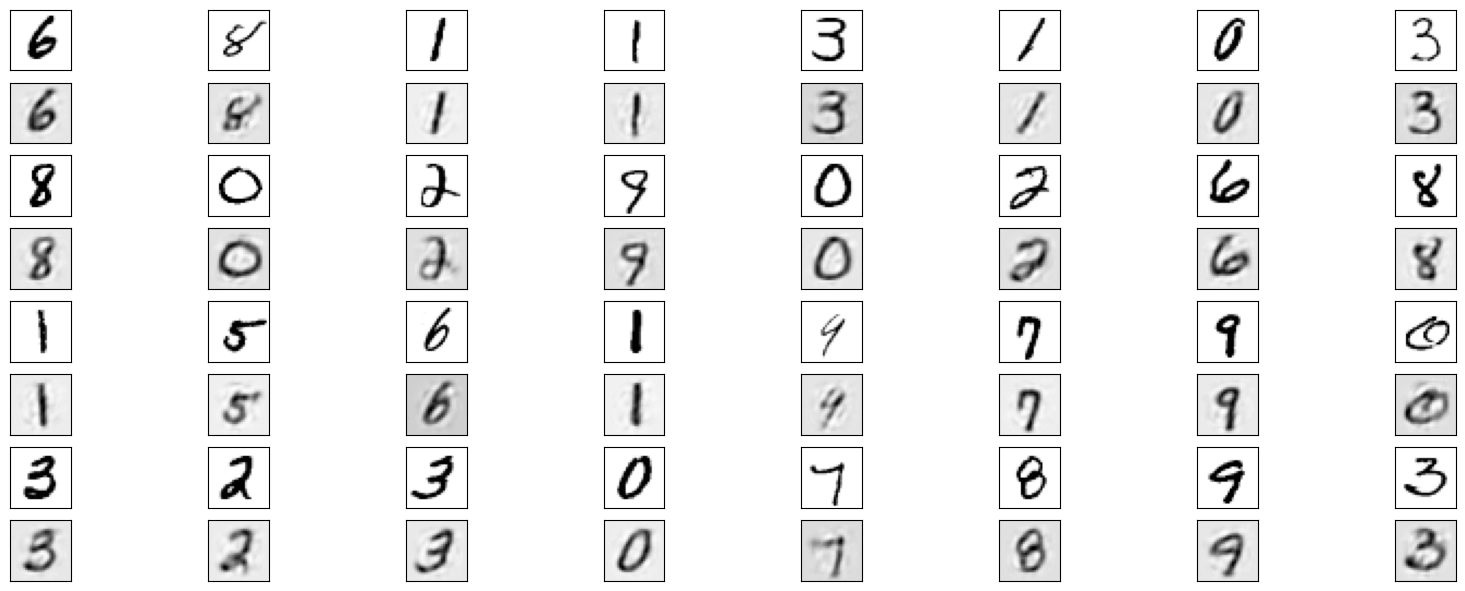

In [58]:
drawComparisons( net )

It looks like this network works really well except for some reseidual "grey" noise!  We could try feeding these into our classifier from yesterday as well to see if our old network can still identify the digits

We have to go deeper!

In [39]:
#based on https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1

class DeeperNet(nn.Module):
    def __init__(self, inputLen):
        super(DeeperNet, self).__init__()
        self.inputLen = inputLen
        self.encodedSize = 32
        
        self.fc1 = nn.Linear(self.inputLen, 128)
        self.fc2 = nn.Linear(128, 64) #scale down to 64 features
        self.fc3 = nn.Linear(64, self.encodedSize) #scale down to 64 features
        
        
        self.fc4 = nn.Linear(self.encodedSize, 64)
        self.fc5 = nn.Linear(64, 128)
        self.fc6 = nn.Linear(128, self.inputLen)
        
    def compress(self, x):    
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        #now we have a low-d representation of our data.  If we were doing compression, we'd store this
        return x
    
    def decompress(self, x):
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x
    
    def forward(self, x):
        x = self.compress(x)
        x = self.decompress(x)
       
        return x

deeperNet = DeeperNet(28*28) # treat these as just 28 D vectors

In [62]:
train( deeperNet, 3 )

[1,  2000] loss: 0.07290289
[1,  4000] loss: 0.07314031
[1,  6000] loss: 0.07246317
epoch : 1/3, loss = 0.07273327
[2,  2000] loss: 0.07184839
[2,  4000] loss: 0.07228002
[2,  6000] loss: 0.07161583
epoch : 2/3, loss = 0.07182218
[3,  2000] loss: 0.07088188
[3,  4000] loss: 0.07110248
[3,  6000] loss: 0.07114428
epoch : 3/3, loss = 0.07103962


overall loss:  86.39773553609848


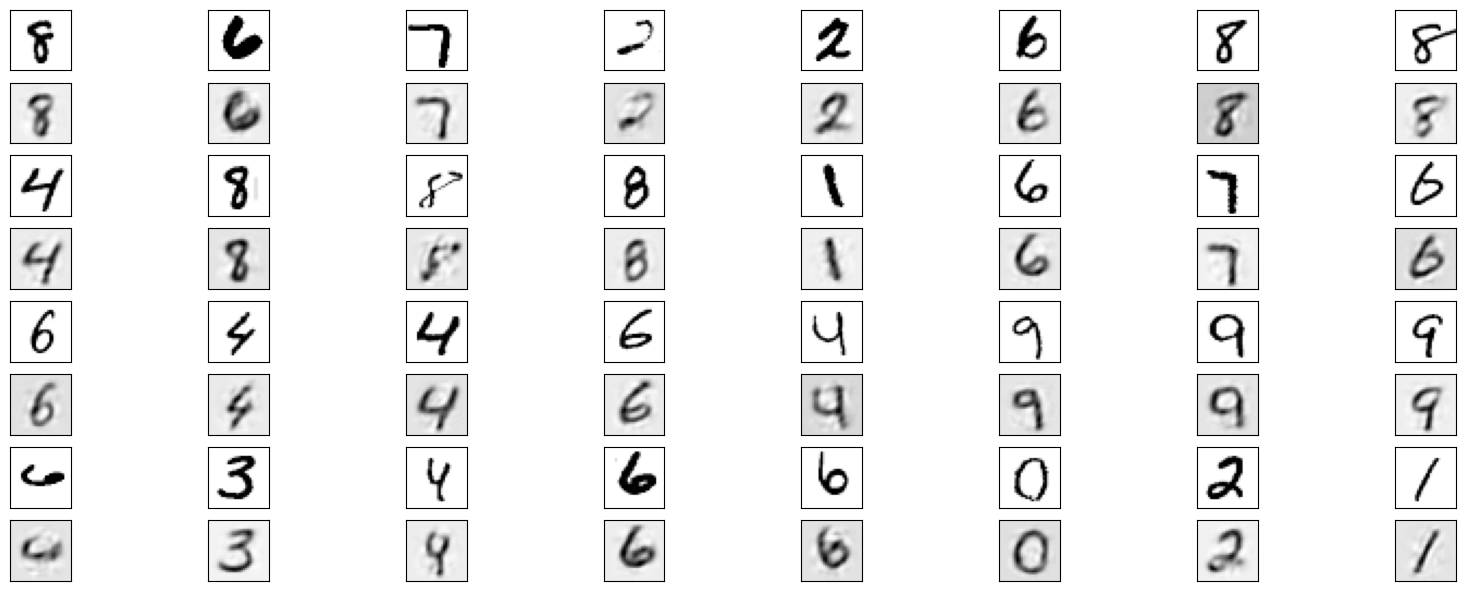

In [64]:
evaluate( deeperNet )
drawComparisons( deeperNet )

The reduced representation is half the size as before, so not too surprising the error is higher, but this still looks pretty good!

In [42]:
# specify the reduced representation size to see how small we can go while getting reasonable results
class DeeperNarrowerNet(nn.Module):
    def __init__(self, inputLen, encodedSize):
        super(DeeperNarrowerNet, self).__init__()
        self.inputLen = inputLen
        self.encodedSize = encodedSize
        
        self.fc1 = nn.Linear(self.inputLen, 128)
        self.fc2 = nn.Linear(128, 64) #scale down to 64 features
        self.fc3 = nn.Linear(64, self.encodedSize) #scale down to 64 features
        
        
        self.fc4 = nn.Linear(self.encodedSize, 64)
        self.fc5 = nn.Linear(64, 128)
        self.fc6 = nn.Linear(128, self.inputLen)
        
    def compress(self, x):    
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        #now we have a low-d representation of our data.  If we were doing compression, we'd store this
        return x
    
    def decompress(self, x):
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x
    
    def forward(self, x):
        x = self.compress(x)
        x = self.decompress(x)
       
        return x



[1,  2000] loss: 0.19193792
[1,  4000] loss: 0.14889094
[1,  6000] loss: 0.13904817
epoch : 1/4, loss = 0.15482089
[2,  2000] loss: 0.13112493
[2,  4000] loss: 0.12914201
[2,  6000] loss: 0.12688863
epoch : 2/4, loss = 0.12833951
[3,  2000] loss: 0.12383076
[3,  4000] loss: 0.12259087
[3,  6000] loss: 0.12220476
epoch : 3/4, loss = 0.12265251
[4,  2000] loss: 0.12042554
[4,  4000] loss: 0.11975344
[4,  6000] loss: 0.11947578
epoch : 4/4, loss = 0.11971731
overall loss:  148.09655456244946


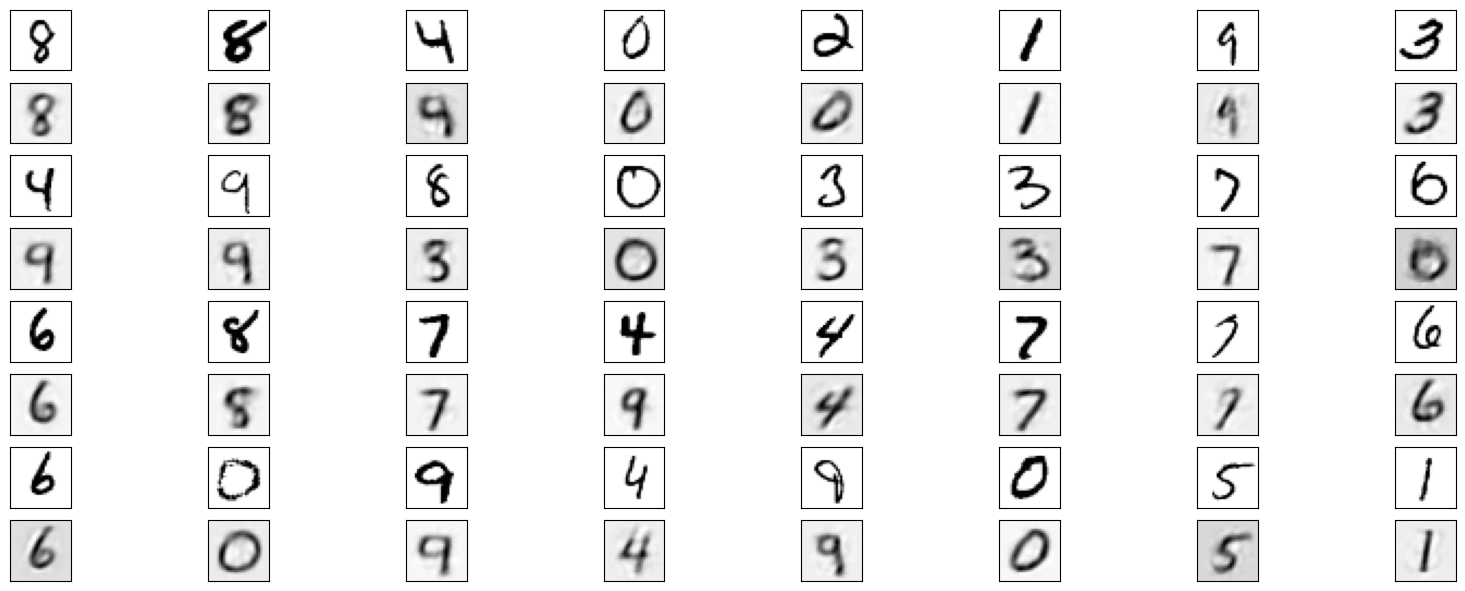

In [43]:
deeperNarrowerNet8 = DeeperNarrowerNet(28*28, 8) # treat these as just 28 D vectors
train(deeperNarrowerNet8, 4)
evaluate(deeperNarrowerNet8)
drawComparisons(deeperNarrowerNet8)

[1,  2000] loss: 0.18016156
[1,  4000] loss: 0.13282102
[1,  6000] loss: 0.11996026
epoch : 1/4, loss = 0.13833506
[2,  2000] loss: 0.11114951
[2,  4000] loss: 0.10771148
[2,  6000] loss: 0.10562247
epoch : 2/4, loss = 0.10736881
[3,  2000] loss: 0.10277676
[3,  4000] loss: 0.10170928
[3,  6000] loss: 0.10041028
epoch : 3/4, loss = 0.10126467
[4,  2000] loss: 0.09913078
[4,  4000] loss: 0.09837029
[4,  6000] loss: 0.09809722
epoch : 4/4, loss = 0.09836665
overall loss:  120.1081593260169


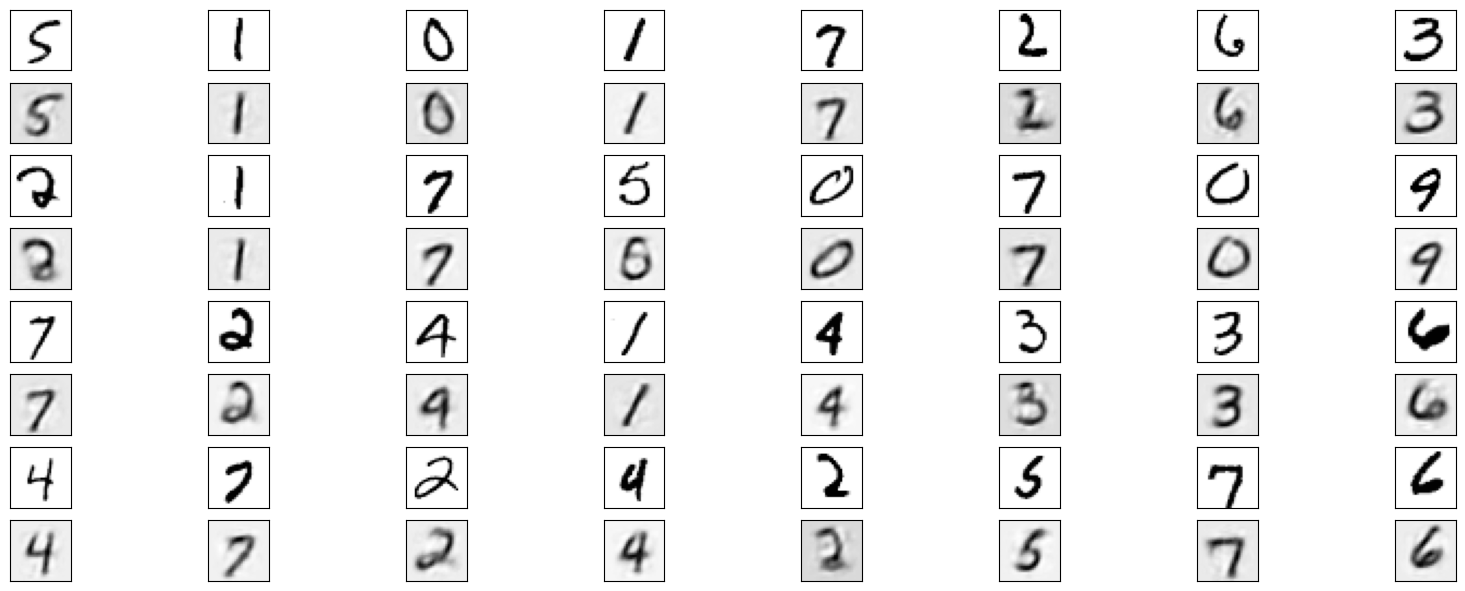

In [44]:
deeperNarrowerNet16 = DeeperNarrowerNet(28*28, 16) # treat these as just 28 D vectors
train(deeperNarrowerNet16, 4)
evaluate(deeperNarrowerNet16)
drawComparisons(deeperNarrowerNet16)

Next we'll see if we can use this for anomaly detection.  I have a couple of "hand written" digits and some letters.  Hopefully the reconstruction error for the letters will be higher than for the digits

In [45]:
from PIL import Image
from PIL import ImageOps
import numpy as np

In [46]:

imgs = [transforms.Normalize((0.5),(0.5))( #scale things the same way we did for our training/testing data
    transforms.ToTensor()( #convert to a pytorch tensor
        np.array(ImageOps.invert( #in my images, black/white are inverted, so switch them back
            Image.open(fname).convert('L') # load the image, and convert to greyscale
        )))) for fname in 
        ["j.png", "k.png", "4.png"]]
#duplicate them so it's the length of a batch
imgs = torch.stack(imgs)
imgs.shape

torch.Size([3, 1, 28, 28])

tensor(0.0810)
tensor(0.1385)
tensor(0.0688)


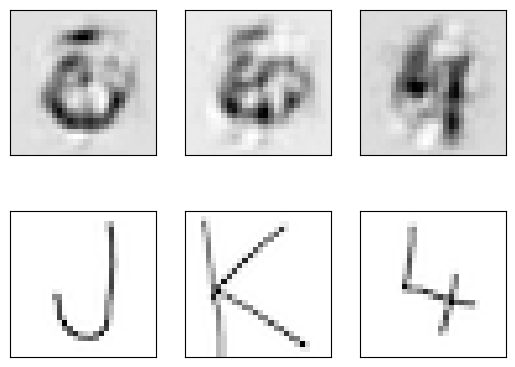

In [47]:
with torch.no_grad():
    outputs = deeperNarrowerNet8(imgs.view(-1, 28*28))
    individualLosses = nn.MSELoss()
    
    
    for j in range(3):
        losses = individualLosses(outputs[j].reshape(1,1, 28,28), imgs[j])
        print(losses)
        ax = plt.subplot(2, 3, j + 1)
        plt.imshow(outputs[j].reshape((28,28)), cmap="Greys", interpolation=None)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, 3, j + 1 + 3)
        plt.imshow(imgs[j].reshape((28,28)), cmap="Greys", interpolation=None)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

As hoped/expected, the "K" has the highest reconstruction error... it looks the least like any of the digits.

Let's try using CNN layers, since we're working with images after all...

In [48]:
class CnnNet(nn.Module):
    def __init__(self):
        super(CnnNet, self).__init__()
        
        self.encodedSize = 32
        
        self.c1Out = 8 # filters from first conv layer
        self.c2Out = 8 # filters from 2nd conv layer
        
        #the padding here puts a "border" of 0s around the image, so that convolution layers don't "shrink" the image
        
        self.cv1 = nn.Conv2d(1, self.c1Out, 3, padding=1) #stick with 3x3 filters
        #output is 8x 28x28 images
        self.pool = nn.MaxPool2d(2,2)
        self.cv2 = nn.Conv2d(self.c1Out, self.c2Out, 3, padding=1)
        #reuse pool here
        
        self.downscaledSize = 28//4 #we add padding, so the conv2d layers don't change the size, just the max pools
        self.flattenedSize = self.downscaledSize*self.downscaledSize*self.c2Out
        
        self.fc1 = nn.Linear(self.flattenedSize, 64)
        self.fc2 = nn.Linear(64, self.encodedSize) #scale down to 64 features

        #now we're encoded, so go define decoding pieces
        
        self.fc3 = nn.Linear(self.encodedSize, 64) #scale down to 64 features
        self.fc4 = nn.Linear(64, self.flattenedSize)
        
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        # the padding is very important here so we don't have to guess a "frame" of pixels around the image
        self.cv3 = nn.Conv2d(self.c2Out, self.c1Out, 3, padding=1)
        # apply upsample again
        self.cv4 = nn.Conv2d(self.c1Out, 1, 3, padding=1)
        
        
    def compress(self, x):
        x = self.cv1(x)
        #print("shape after cv1", x.shape)
        x = F.relu(self.pool(x))
        #print("shape after pool1", x.shape)
        x = self.cv2(x)
        #print("after cv2", x.shape)
        x = F.relu(self.pool(x))
        #print("after pool 2", x.shape)
        x = x.view(-1, self.flattenedSize)
        #print("flattened shape", x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #now we have a low-d representation of our data.  If we were doing compression, we'd store this
        return x
    
    def decompress(self, x):
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        #print(x.shape)
        x = x.view(-1, self.c2Out, self.downscaledSize, self.downscaledSize)
        #print("unflattened shape", x.shape)
        x = self.upsample(x)
        #print("upsample", x.shape)
        x = F.relu(self.cv3(x))
        #print(x.shape, "after cv3")
        x = self.cv4(self.upsample(x))
        #print(x.shape, "after both upsamples")
        return x
    
    def forward(self, x):
        x = self.compress(x)
        x = self.decompress(x)
       
        return x

cnnNet = CnnNet() # treat these as just 28 D vectors

In [49]:
#same as we did before except for the reshaping.  CNNs understand 2D images, so we don't want to flatten

# mean-squared error loss
# this is the normal "least squares" error function, divided by the number of data points
criterion = nn.MSELoss()

def trainCNN(model, epochs):
    # create an optimizer object
    # Adam optimizer with learning rate 1e-3
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    
    
    train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=8, shuffle=True, num_workers=0)
    
    for epoch in range(epochs):
        loss = 0
        
        running_loss = 0
        
        for i, data in enumerate(train_loader, 0):

            #same as yesterday, except we're not even looking at the labels!
            # since we're not using a CNN, we need to "flatten" the input images
            batch_features = data[0]
        
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()
        
            # compute reconstructions
            outputs = model(batch_features)
            #print(batch_features.shape)
            #print(outputs.shape)
            # compute training reconstruction loss
            # again, same idea as yesterday, but we're measuring the error slightly differently
            # how well does the reconstructed image match the input image?
            train_loss = criterion(outputs, batch_features)
        
            # compute accumulated gradients
            train_loss.backward()
        
            # perform parameter update based on current gradients
            optimizer.step()
        
            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()
    
            # print statistics
            running_loss += train_loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.8f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    
        # compute the epoch training loss
        loss = loss / len(train_loader)
    
        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.8f}".format(epoch + 1, epochs, loss))

def evaluateCNN(model):
    test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=8, shuffle=True, num_workers=0)
    total_loss = 0
    with torch.no_grad():
        for data in test_loader:
            images = data[0]
            outputs = model(images)
            test_loss = criterion(outputs, images)
            total_loss += test_loss.item()

    print("overall loss: ", total_loss)

In [65]:
trainCNN(cnnNet, 4)
evaluateCNN(cnnNet)

[1,  2000] loss: 0.00003441
[1,  4000] loss: 0.00003706
[1,  6000] loss: 0.00002982
epoch : 1/4, loss = 0.05855812
[2,  2000] loss: 0.00003644
[2,  4000] loss: 0.00003309
[2,  6000] loss: 0.00003398
epoch : 2/4, loss = 0.05651548
[3,  2000] loss: 0.00004231
[3,  4000] loss: 0.00003625
[3,  6000] loss: 0.00002861
epoch : 3/4, loss = 0.05520114
[4,  2000] loss: 0.00002895
[4,  4000] loss: 0.00002598
[4,  6000] loss: 0.00004168
epoch : 4/4, loss = 0.05423557
overall loss:  64.53916912898421


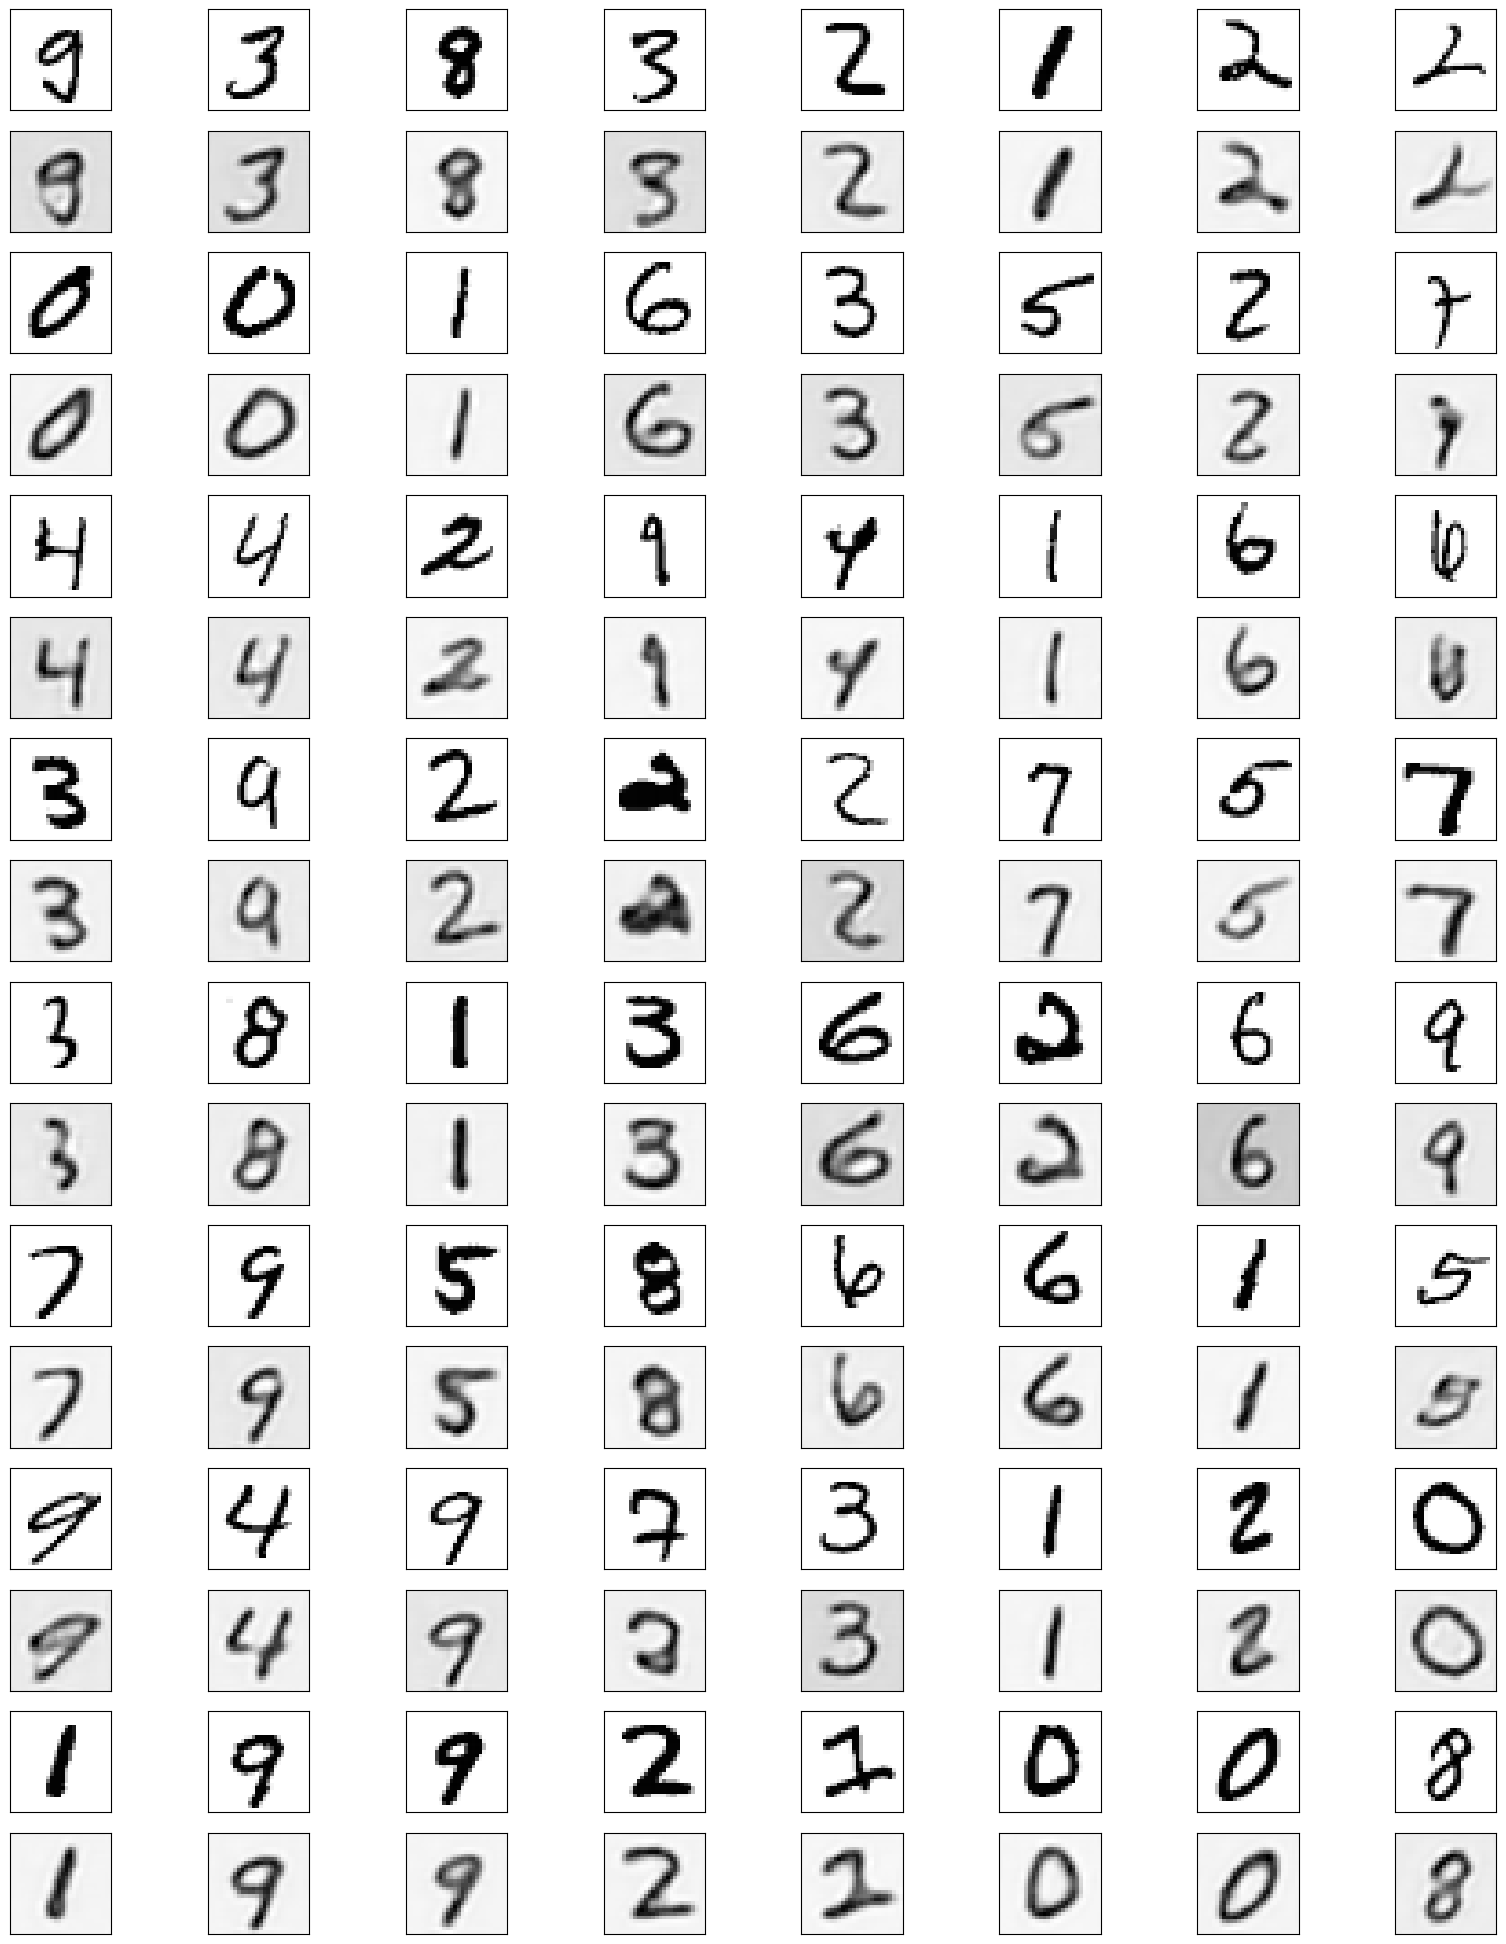

In [66]:
def drawComparisonsCNN(model):
    test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=8, shuffle=True, num_workers=0)
    plt.figure(figsize=(20, 25))
    for i, batch in enumerate(test_loader):
        if i >= 8: break
        images = batch[0]
        #print(images.shape)
        with torch.no_grad():
            reconstructed = model(images)
            for j in range(len(images)):
                #draw the original image
                ax = plt.subplot(16, 8, i*16 + j + 1)
                plt.imshow(images[j].reshape((28,28)), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            
                #and the reconstructed version in the next row
                ax = plt.subplot(16, 8, i*16 + j + 1 + 8)
                plt.imshow(reconstructed[j].reshape((28,28)), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
        
drawComparisonsCNN(cnnNet)

Wow, that looks super good!

In [52]:
class CnnTinyNet(nn.Module):
    def __init__(self):
        super(CnnTinyNet, self).__init__()
        
        self.encodedSize = 4
        
        self.c1Out = 8 # filters from first conv layer
        self.c2Out = 8 # filters from 2nd conv layer
        
        #the padding here puts a "border" of 0s around the image, so that convolution layers don't "shrink" the image
        
        self.cv1 = nn.Conv2d(1, self.c1Out, 3, padding=1) #stick with 3x3 filters
        #output is 8x 28x28 images
        self.pool = nn.MaxPool2d(2,2)
        self.cv2 = nn.Conv2d(self.c1Out, self.c2Out, 3, padding=1)
        #reuse pool here
        
        self.downscaledSize = 28//4 #we add padding, so the conv2d layers don't change the size, just the max pools
        self.flattenedSize = self.downscaledSize*self.downscaledSize*self.c2Out
        
        self.fc1 = nn.Linear(self.flattenedSize, 64)
        self.fc2 = nn.Linear(64, self.encodedSize) #scale down to 64 features

        #now we're encoded, so go define decoding pieces
        
        self.fc3 = nn.Linear(self.encodedSize, 64) #scale down to 64 features
        self.fc4 = nn.Linear(64, self.flattenedSize)
        
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        # the padding is very important here so we don't have to guess a "frame" of pixels around the image
        self.cv3 = nn.Conv2d(self.c2Out, self.c1Out, 3, padding=1)
        # apply upsample again
        self.cv4 = nn.Conv2d(self.c1Out, 1, 3, padding=1)
        
        
    def compress(self, x):
        x = self.cv1(x)
        #print("shape after cv1", x.shape)
        x = F.relu(self.pool(x))
        #print("shape after pool1", x.shape)
        x = self.cv2(x)
        #print("after cv2", x.shape)
        x = F.relu(self.pool(x))
        #print("after pool 2", x.shape)
        x = x.view(-1, self.flattenedSize)
        #print("flattened shape", x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #now we have a low-d representation of our data.  If we were doing compression, we'd store this
        return x
    
    def decompress(self, x):
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        #print(x.shape)
        x = x.view(-1, self.c2Out, self.downscaledSize, self.downscaledSize)
        #print("unflattened shape", x.shape)
        x = self.upsample(x)
        #print("upsample", x.shape)
        x = F.relu(self.cv3(x))
        #print(x.shape, "after cv3")
        x = self.cv4(self.upsample(x))
        #print(x.shape, "after both upsamples")
        return x
    
    def forward(self, x):
        x = self.compress(x)
        x = self.decompress(x)
       
        return x

cnnTinyNet = CnnTinyNet() # treat these as just 28 D vectors

In [53]:
trainCNN(cnnTinyNet, 4)
evaluateCNN(cnnTinyNet)

[1,  2000] loss: 0.00013066
[1,  4000] loss: 0.00010357
[1,  6000] loss: 0.00010415
epoch : 1/4, loss = 0.22349660
[2,  2000] loss: 0.00011065
[2,  4000] loss: 0.00009849
[2,  6000] loss: 0.00008871
epoch : 2/4, loss = 0.19153885
[3,  2000] loss: 0.00009689
[3,  4000] loss: 0.00007867
[3,  6000] loss: 0.00009328
epoch : 3/4, loss = 0.18185865
[4,  2000] loss: 0.00008479
[4,  4000] loss: 0.00008304
[4,  6000] loss: 0.00007114
epoch : 4/4, loss = 0.17674321
overall loss:  219.77214937657118


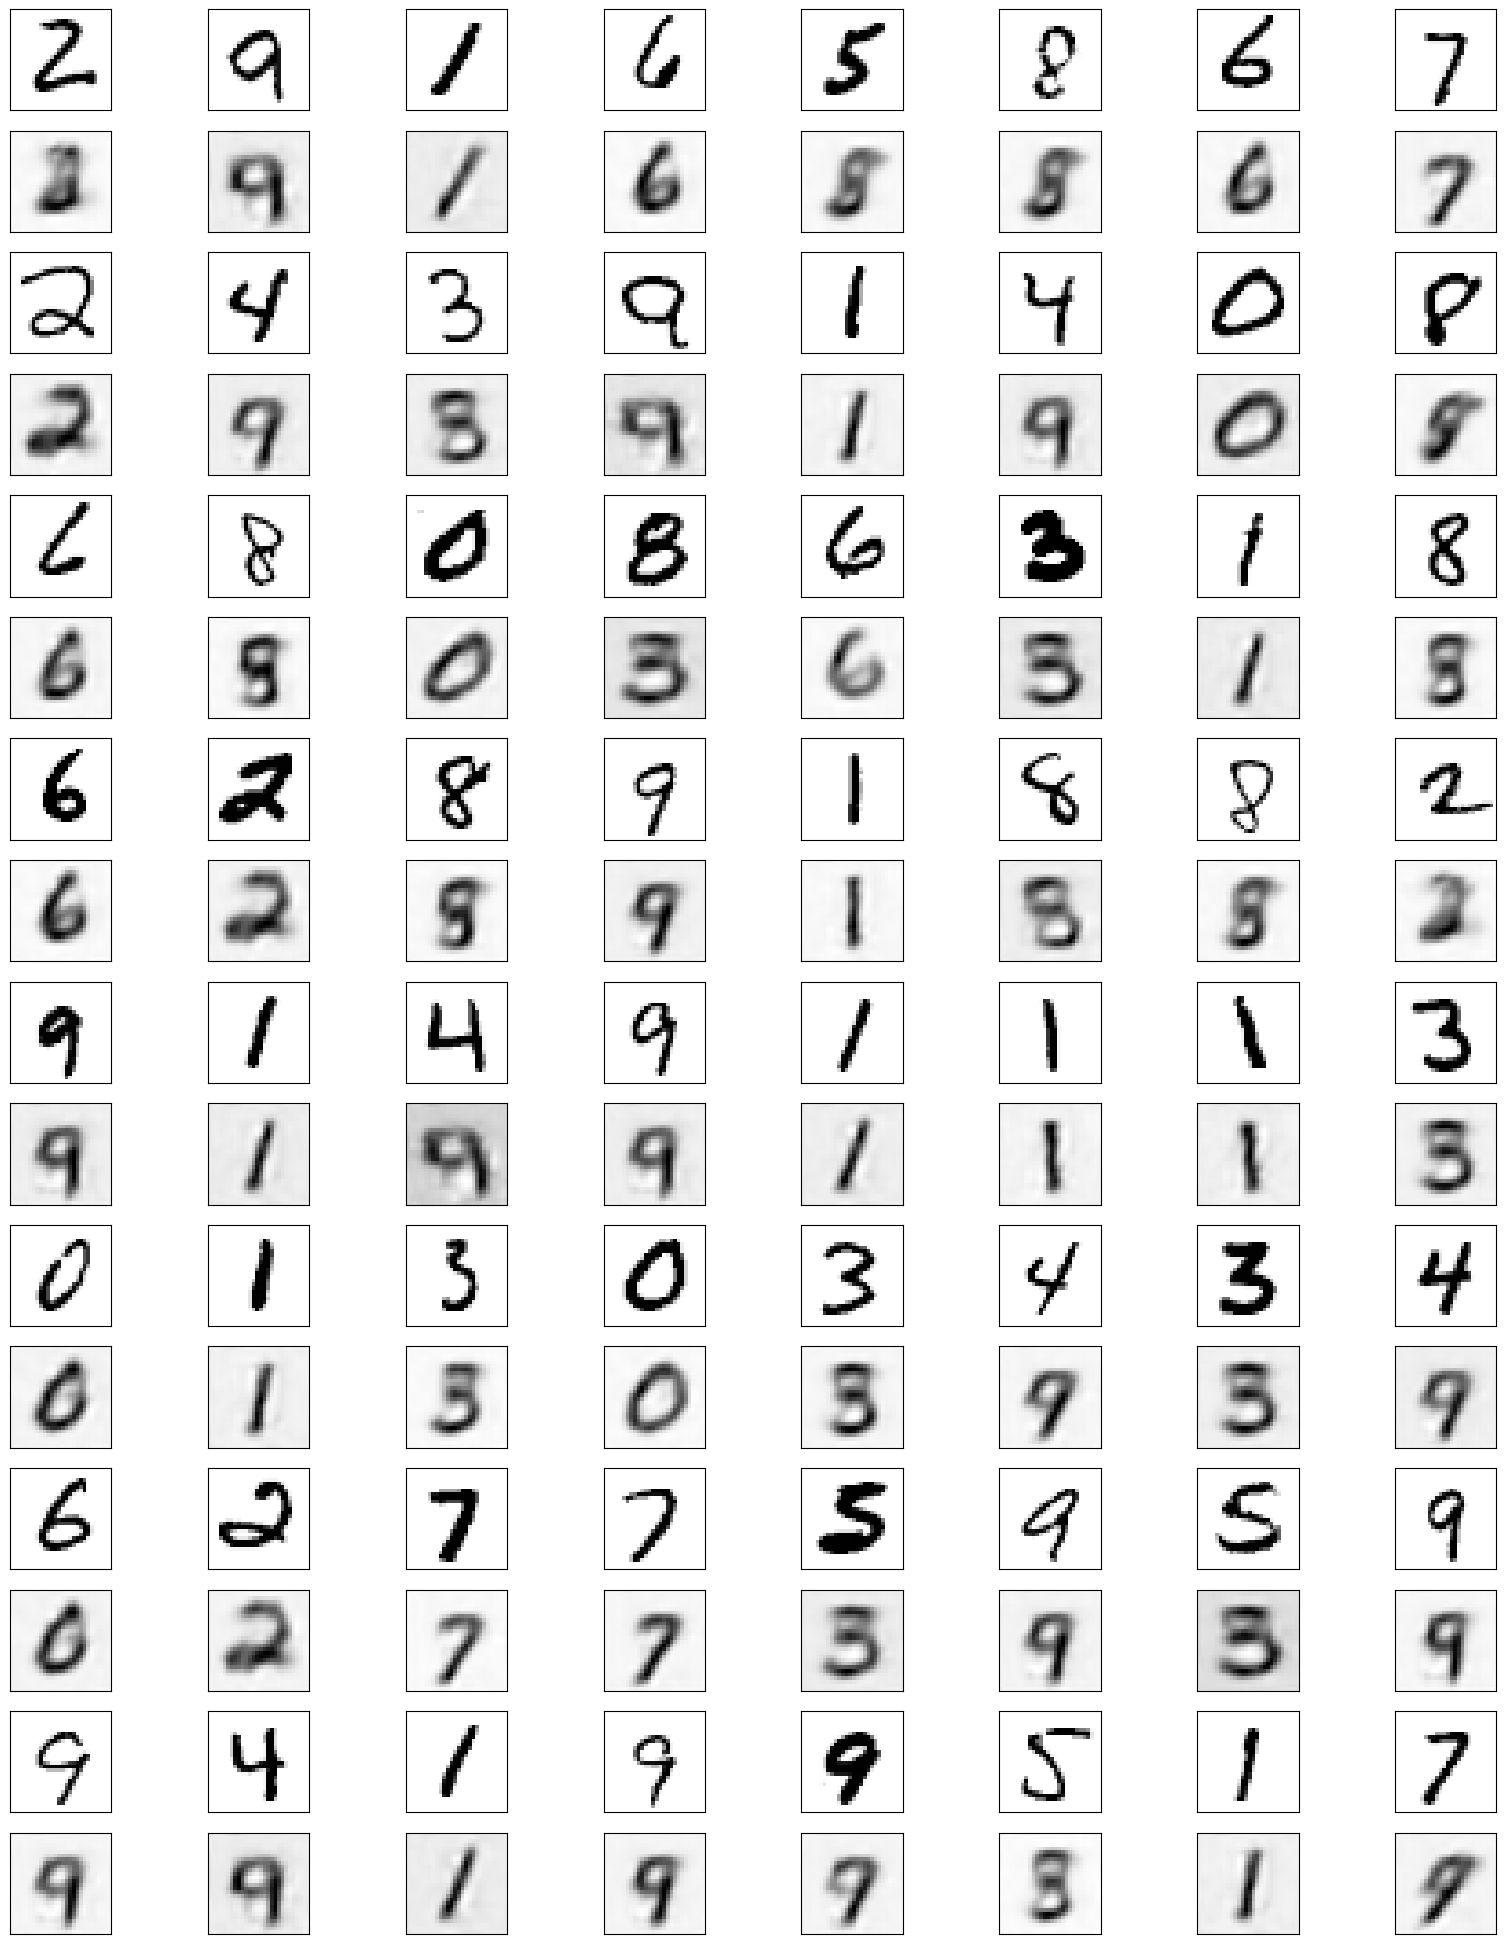

In [54]:
drawComparisonsCNN(cnnTinyNet)

In [55]:
compressed = np.array([.2,.2,.2,.2])
compressed = torch.tensor(compressed, dtype=torch.float)

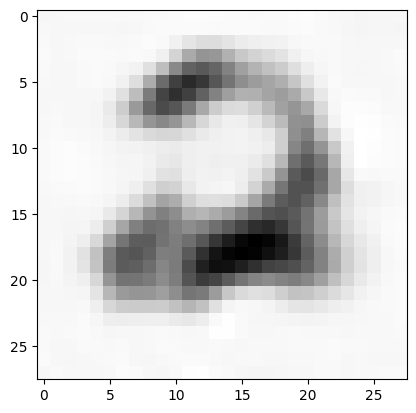

In [56]:
output = cnnTinyNet.decompress(compressed)
plt.imshow(output.detach().numpy().reshape(28,28), cmap="Greys", interpolation=None)